## Challenge Model Comparison
You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [10]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Source : https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls
df = pd.read_csv("../Unit2/datasets/NY-nKnowOffenses.csv")
df.columns = ['City', 'Population', 'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated assault', 'PropertyCrime', 'Burglary', 'Larceny theft', 'Motor vehicle theft', 'Arson']
df = df.iloc[4:]
df = df.iloc[:-3]
df['PropertyCrime'] = df['PropertyCrime'].str.replace(',','').astype('int')
df['Robbery'] = df['Robbery'].str.replace(',','').astype('int')
df['Population'] = df['Population'].str.replace(',','').astype('int')
df['Population_2'] = df['Population'].apply(lambda x: x * x)
df['Murder']= df['Murder and nonnegligent manslaughter'].astype('int')
df['Motor_vehicle_theft'] = df['Motor vehicle theft'].str.replace(',','').astype('int')
df['RobberyClass'] = df['Robbery'].apply(lambda x: 1 if int(x) > 0 else 0)
df['MurderClass'] = df['Murder and nonnegligent manslaughter'].apply(lambda x: 1 if int(x) > 0 else 0)
df['Burglary'] = df['Burglary'].str.replace(',','').astype('int')
#Drop the outlier
df = df.drop(df[df.Robbery == 19170].index)
df.describe()

,Population,Robbery,PropertyCrime,Burglary,Population_2,Murder,Motor_vehicle_theft,RobberyClass,MurderClass
count,347.00,347.00,347.00,347.00,347.00,347.00,347.00,347.00,347.00
mean,15956.69,17.87,385.75,72.17,985840709.76,0.61,14.59,0.60,0.14
std,27080.22,94.97,1034.37,264.94,5067232380.43,3.71,67.68,0.49,0.35
min,526.00,0.00,0.00,0.00,276676.00,0.00,0.00,0.00,0.00
25%,2997.00,0.00,40.00,6.00,8982153.00,0.00,0.00,0.00,0.00
50%,7187.00,1.00,112.00,17.00,51652969.00,0.00,2.00,1.00,0.00
75%,18160.50,5.00,340.50,51.00,329804222.50,0.00,7.00,1.00,0.00
max,258789.00,1322.00,12491.00,3458.00,66971746521.00,47.00,957.00,1.00,1.00


### OLS Model

In [11]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
 
class statsmodel(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self,data,dummy):
        self.model = self.sm_class(self.formula,data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

In [20]:
Y = df['PropertyCrime']#.values.reshape(-1, 1)
X = df[['RobberyClass','MurderClass', 'Population','Motor_vehicle_theft']]
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

df_train = X_train.copy()
df_train['PropertyCrime'] = y_train.copy()

linear_formula = 'PropertyCrime ~ RobberyClass+MurderClass+Population+Motor_vehicle_theft'

# create a model
clf = statsmodel(smf.ols, linear_formula)
# fit a model
clf.fit(df_train, None)


# Inspect the results.
print('\nParameters: \n', clf.result.params)
print('\np-values: \n', clf.result.pvalues)
print('\nR-squared:')
print(clf.result.rsquared)
print('\nConfidence intervals:')
print(clf.result.conf_int())

y_pred = clf.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))

print('\nLess overfitting:')
print('coss-val-score:')
score = cross_val_score(clf, df, df['PropertyCrime'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Parameters: 
 Intercept              -6.70
RobberyClass          111.41
MurderClass           134.49
Population              0.01
Motor_vehicle_theft    11.15
dtype: float64

p-values: 
 Intercept             0.79
RobberyClass          0.00
MurderClass           0.02
Population            0.00
Motor_vehicle_theft   0.00
dtype: float64

R-squared:
0.9424622979780002

Confidence intervals:
                         0      1
Intercept           -57.36  43.96
RobberyClass         39.39 183.42
MurderClass          22.57 246.41
Population            0.01   0.01
Motor_vehicle_theft  10.30  12.00

mean-squared:
51504.34942882877

Less overfitting:
coss-val-score:
Accuracy: 0.78 (+/- 0.37)


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

for i in range(15):
    
    print('\nk = ', i+1)
    
    X = df[['RobberyClass','MurderClass', 'Population','Motor_vehicle_theft']]
    Y = df['PropertyCrime']
    knn = neighbors.KNeighborsRegressor(n_neighbors=i+1)
    knn.fit(X, Y)
    
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=i+1, weights='distance')
    knn_w.fit(X, Y)


    score = cross_val_score(knn, X, Y, cv=5)
    print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
    score_w = cross_val_score(knn_w, X, Y, cv=5)
    print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))


k =  1
Unweighted Accuracy: 0.28 (+/- 0.84)
Weighted Accuracy: 0.28 (+/- 0.84)

k =  2
Unweighted Accuracy: 0.43 (+/- 1.06)
Weighted Accuracy: 0.38 (+/- 0.82)

k =  3
Unweighted Accuracy: 0.61 (+/- 0.53)
Weighted Accuracy: 0.46 (+/- 0.68)

k =  4
Unweighted Accuracy: 0.59 (+/- 0.36)
Weighted Accuracy: 0.48 (+/- 0.62)

k =  5
Unweighted Accuracy: 0.58 (+/- 0.24)
Weighted Accuracy: 0.48 (+/- 0.53)

k =  6
Unweighted Accuracy: 0.57 (+/- 0.16)
Weighted Accuracy: 0.50 (+/- 0.46)

k =  7
Unweighted Accuracy: 0.57 (+/- 0.11)
Weighted Accuracy: 0.51 (+/- 0.39)

k =  8
Unweighted Accuracy: 0.58 (+/- 0.10)
Weighted Accuracy: 0.53 (+/- 0.34)

k =  9
Unweighted Accuracy: 0.61 (+/- 0.15)
Weighted Accuracy: 0.56 (+/- 0.25)

k =  10
Unweighted Accuracy: 0.62 (+/- 0.18)
Weighted Accuracy: 0.56 (+/- 0.23)

k =  11
Unweighted Accuracy: 0.60 (+/- 0.19)
Weighted Accuracy: 0.56 (+/- 0.21)

k =  12
Unweighted Accuracy: 0.60 (+/- 0.20)
Weighted Accuracy: 0.56 (+/- 0.21)

k =  13
Unweighted Accuracy: 0.60 (+

## Evaluation
From KNN I going to chosse the model with k = 9 <br>
Unweighted Accuracy: 0.61 (+/- 0.15)<br>
Weighted Accuracy: 0.56 (+/- 0.25)

This one has the best balance between accuracy and standard deviation.

### Comparision KNN and OLS
OLS --> Accuracy: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.78 (+/- 0.37)<br>
KNN --> Unweighted Accuracy: 0.61 (+/- 0.15)<br>
KNN --> Weighted Accuracy: &nbsp;&nbsp;&nbsp;   0.56 (+/- 0.25)

Recommendation: Choose the OLS, because even if the KNN has  0.61 (+ 0.15) = 0.76 accuracy and that is still under the mean accuracy of the OLS model
But there is no one unambiguously better model in this notebook.

### What it is about the data that causes the better model to outperform the weaker model.

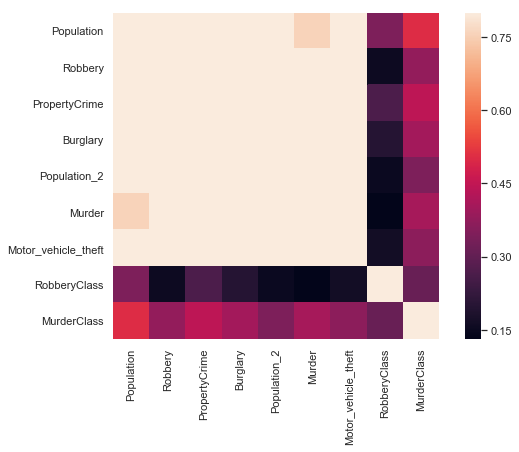

In [25]:
# Make the correlation matrix.
corrmat = df.corr()
# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Probably because of the high correlation of the inputs to the output (property crime) the OLS model is working better than the clustering approach of KNNs. 